
# Day 1: Introduction to Machine Learning for Sentiment Analysis
Today we will learn to build a very simple sentiment predictor, which will allow us to forecast the rating of short product reviews on a scale from very positive (5 stars) to very negative (1 star), based on the content of the text only: we will pretend that we can only see the text, and try if we can predict how many stars the user gave the product based on its tone. This is a useful exercise for situations in which we don't have a "star rating" easily available. For example, if we are running our own business, many users will probably write tweets or Facebook posts in which they state their opinion of the business, and we want to be able to quickly sort the good from the bad reviews.

For this project, we start by setting up our Python environment, and downloading a couple of example datasets (Amazon product reviews) from the Internet. These data were collected by Julian McAuley, UCSD (http://jmcauley.ucsd.edu/data/amazon/)

In [4]:
%matplotlib inline
datadir = './data/'

import urllib.request, os, gzip

## a function to download any amazon products review as given in the dataset collection
## if the "dataset" contains spaces, replace by underscores "_"
##BE REALLY AWARE OF THE SPACES, didnt let be work for so long

def download_data(dataset_name, datadir):
    filename = 'reviews_%s_5.json' % dataset_name
    filepath = os.path.join(datadir, filename)
    if os.path.exists(filepath):
        print("Dataset %s has already been downloaded to %s" % (dataset_name, datadir))
    else:
        url = 'http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/%s.gz' % filename
        urllib.request.urlretrieve(url, filepath + ".gz")
        with gzip.open(filepath + ".gz", 'rb') as fin:
            with open(filepath, 'wb') as fout:
                fout.write(fin.read())
        print("Downloaded dataset %s and saved it to %s" % (dataset_name, datadir))

#dataset = "Beauty"
#download_data(dataset, datadir)
dataset = "Apps_for_Android"
download_data(dataset, datadir)

Dataset Apps_for_Android has already been downloaded to ./data/


The data we use have been stored in the JSON format, which is a standard format for exchanging data over the Internet. The "JS" stands for JavaScript, which we'll learn about in week 5 of the summer of code! But Python allows us to read these data using the json library:

In [5]:
##reading the data to a variable called data[]
import json

def load_data(dataset_name,datadir):
    filepath = os.path.join(datadir, 'reviews_%s_5.json' % dataset_name)
    if not os.path.exists(filepath):
        download_data(dataset_name,datadir)
    data=[]
    with open(filepath, 'r') as f:
        for line in f:                   # read file line by line
            item_hash = hash(line)       # we will use this later for partitioning our data 
            item = json.loads(line)      # convert JSON string to Python dict
            item['hash'] = item_hash     # add hash for identification purpose
            data.append(item)
    print("Loaded %d data for datasets %s" % (len(data), dataset_name))
    return data

In [6]:
# load the data...
apps = load_data(dataset, datadir)
# ... and have a look at an example item (item number 9426):
print(apps[367668])

Loaded 752937 data for datasets Apps_for_Android
{'reviewerID': 'A2RK3QEUEFRNAN', 'asin': 'B008S3EJSU', 'reviewerName': 'Daddy Shawn "Writer & daddy."', 'helpful': [3, 3], 'reviewText': "Totally worth the $2.99 I paid.  Lots of fun if you're a fan of fantasy RPGs.  And it's a full game, you don't have to keep buying items with real money to continue.  That's refreshing in this horrible age of micro-transactions.  Pick it up.  You do need a good amount of space available on your device, but it's not as bad as the Final Fantasy games.  For those with new Kindles you won't have any problem.  If you've got an older model you may need to clear out some old games that you don't play.", 'overall': 5.0, 'summary': 'Awesome game & a blast from the past.', 'unixReviewTime': 1395187200, 'reviewTime': '03 19, 2014', 'hash': -782533832592250100}


In [7]:
## good reviews with bad words, these break our machines!!
for i, l in enumerate(apps):
    if l['overall'] == 5.0 and 'horrible' in l['reviewText'] and 'bad' in l['reviewText'] and l['helpful'][0]>0:
        print(i, l['reviewText'])

55851 ...&amp; the losers who gave one star should crawl back into their holes &amp; stay there. What kind of moron gives one star just because they don't do yoga? If I didn't play video games, but got on ign &amp; started throwing out horrible ratings to great games just because I didn't like the looks of them, that would be ridiculous. So is doing it here! Grow up! They give us these apps so we can try them out for free. If it's not for you, move on. If it is, then great. But why would you bash the people giving it to you? Probably because you're pathetic, immature morons, who obviously have no conception of the real world. Or, like the one guy, are a religious fanatic who figures he must give one star to the satanists who made an app like this. Amazon is going to stop the faotd thing if geniuses like you keep giving bad reviews for no reason, &amp; keep complaining that they aren't giving out apps that only you like. They have to give such a huge variety to try to please everyone. P

We see that the dataset contains 160792 data items, with 9 fields called reviewTime, asin, reviewerID, reviewText, unixReviewTime, summary, helpful, reviewerName, overall. For example, this particular review was written on May 20, 2005, by the user 'Erin White "Erin"'. Erin summarized the product as "Has more comforts than Medela!" and gave it 5 stars (out of 5). 7 out of 8 other users rated this review helpful. We also added a hash, which is a single number summarizing the whole data item. For now we can view it as a random ID that is (extremely likely to be) unique for each data item, a bit like a US social security number.

For this project, we will ignore all fields except reviewText and overall (i.e. the overall rating in stars out of five). The idea is to find out if we can infer the star rating (how much the user liked the product) by only looking at the text. This way we can learn how to automatically analyze even texts that come without a star rating, such as Facebook posts or tweets.

Before we start building a complicated AI solution, it is good practice to first implement a very simple "baseline predictor" and measure its performance. This way we get a feeling how hard (or easy) the problem is, For example, we can check for the presence of certain words with strong positive or negative connotations, such as "good" or "fantastic" versus "bad" or "poor". Note that this review contains the words "horrible", "hurt", "bad" and "problem", and still received 5 stars. This gives us already a feeling for the difficulty of the sentiment analysis problem.

Before we develop our first sentiment predictor, we need to partition our data into a **training set, a validation set, and a test set**. This is something we should do in all our machine learning projects. The idea is that our predictor might overgeneralize from the examples we show it if we are not careful. This is a bit like a child whom you have shown how an iPad works, and then they try to swipe everything that looks like a screen (the TV, the microwave etc.)

For instance, the example review listed above might be the only review with the phrase "6 hours" in it, and our predictor might learn a rule that the phrase "6 hours" is indicative of a high star rating. Such a rule would be unlikely to generalize well to new reviews that we didn't show to the predictor while it was training. So after training our predictor (using only examples from the training set), we need to be able to measure its performance on reviews it hasn't seen yet, which is what the test set is for. We use the validation set because we may want to explore different predictor variants and get an idea how well they perform on unseen examples before committing to one.

Therefore the general procedure when developing a predictor using machine learning is as follows:

Train several variants of a predictor using examples from the training set only. Use the predictor performance on the validation set to select a single best predictor among all the possible variants. This step also involves debugging our implementation of the predictor, tweaking its parameters etc. Use the test set to get an idea how well our best predictor is expected to perform on unseen data. This step should only be performed once, at the very end of the experiment: if we tweak our predictor based on its performance on the test set, we simply may find a variant that "gets lucky" on the test set, and overestimate its accuracy on truly unseen examples. A common rule of thumb is to use 60% of our data for the training, 20% for validation, and 20% for testing. We could simply take the first 60% of our review data for training, but then we have to assume that the dataset has been "mixed" well in advance. We achieve a better randomization by using the hash we computed from the JSON string and checking its modulus 10:

In [8]:
def partition_train_validation_test(data):
    # 60% : modulus is 0, 1, 2, 3, 4, or 5
    data_train = [item for item in data if item['hash']%10<=5]  
    # 20% : modulus is 6 or 7
    data_valid = [item for item in data if item['hash']%10 in [6,7]] 
    # 20% : modulus is 8 or 9
    data_test  = [item for item in data if item['hash']%10 in [8,9]] 
    return data_train, data_valid, data_test
    
apps_train, apps_valid, apps_test = partition_train_validation_test(apps)

print("Now we have", len(apps_train), "training examples,", len(apps_valid),
      "validation examples, and", len(apps_test), "test examples")

Now we have 451730 training examples, 150797 validation examples, and 150410 test examples


Prediction algorithms generally work with numbers instead of text. Therefore we need to preprocess our text by extracting from it numeric **"features"** that we can afterwards feed into our predictor. For our simple baseline predictor, we will use only two features: the frequency of positive words in the review ("good", "great", "like") and the frequency of negative words in the review ("bad", "horrible", "dislike"). Let's call these two features **fpos** and **fneg**. Our hypothesis is that reviews with many positive words (high fpos) are likely to receive 4 or 5 stars, while reviews with many negative words (high fneg) will probably receive 1 or 2 stars. Since reviews differ in their length, it makes sense to express the **frequency of positive and negative words as a fraction of the total number of words in the review. Therefore fpos and fneg will be numbers between 0 and 1**.

For example, assume the review text is "This is a good, great, fantastic, amazing, wonderful, super product!". We count six positive words and zero negative words (out of ten words in total), so fpos == 0.6 (6/10) and fneg == 0.0 (0/10).

On the other hand, the review "This is a bad, atrocious, terrible, dreadful, awful, abysmal product!" will have fpos == 0.0 (0/10) and fneg == 0.6 (6/10). Alternatively we could decide to discount all **"stop words"**: these are extremely common words such as "this", "is" or "a", which are required by the syntax of the English language but don't really carry semantic meaning. If we strip out these three words, we have fpos == 0.857 (6/7) in the first example, and fneg == 0.857 in the second example.

Writing down all positive and negative words in the English language by hand would be a very long and tedious task. Thankfully we don't have to do this ourselves, since it was already done by Hu and Liu (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html). The Hu-Liu lexicon of positive and negative opinion words is available as part of NLTK:

In [10]:
from nltk.corpus import opinion_lexicon
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

import random
random.seed(1234)
print("Some positive words:", ", ".join(random.sample(positive_words, 10))) #notice the 'explode' happening, , before each word
print("Some negative words:", ", ".join(random.sample(negative_words, 10)))

intersection = positive_words & negative_words ## intersection using ONLY '&' WOAH!!
print("Words that appear in both sets: " + ", ".join(intersection))

Some positive words: dazzled, colorful, dreamland, thinner, dawn, entrancing, benevolent, champ, hug, supporter
Some negative words: plight, irksome, bemused, misrepresentation, discontentedly, stupify, conflicted, sloppy, stinging, reviled
Words that appear in both sets: envious, enviousness, enviously


While sentiment labeling of individual words can be subjective, most people would agree with the classification as positive or negative for these examples. Notice that the Hu-Liu lexicon contains different word forms: for example, it contains both adjectives ("wholesome") and adverbs ("harshly"), and verbs appear both in the base form ("blurt") and in inflected forms ("picketing"). **It also contains common misspellings ("flicering" instead of "flickering")**. This is why we will take the words in the reviews as they are (apart from minor preprocessing steps such as converting from upper-case to lower-case), and won't apply more sophisticated preprocessing techniques such as stemming.

We can now write a function that takes a review text and outputs the number of positive and negative words in the review as a fraction of the total number of words in the review (excluding stop words and punctuation). Note that we have to deal with the **special case when the total number of words is zero**, which happens if the review text is empty. Otherwise we'll end up dividing by zero, and you'll remember from high school that this is not allowed!

In [11]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

#sent_tokenize() divides a para into sentences and word_tokenize() divides a sentence into words

eng_stopwords = set(stopwords.words('english'))

def my_tokenize(text):
    # split text into lower-case tokens, removing all-punctuation tokens and stopwords
    tokens = []
    for sentence in sent_tokenize(text):
        tokens.extend(x for x in word_tokenize(sentence.lower()) 
                      if x not in eng_stopwords and any(i.isalpha() for i in x)) #any means the word has atleast 1 alphabet
    return tokens

def pos_neg_fraction(text):
    tokens = my_tokenize(text)
    count_pos, count_neg = 0, 0
    for t in tokens:
        if t in positive_words:
            count_pos += 1
        if t in negative_words:
            count_neg += 1
    count_all = len(tokens)
    if count_all != 0:
        return count_pos/count_all, count_neg/count_all ## notice returning a pair
    else:
        return 0., 0.
    
pos_example = 'This is a good, great, fantastic, amazing, wonderful, super product!!!'
neg_example = 'This is a bad, atrocious, terrible, dreadful, awful, abysmal product!!!'
print(pos_neg_fraction(pos_example))
print(pos_neg_fraction(neg_example))

(0.8571428571428571, 0.0)
(0.0, 0.8571428571428571)



For our two example sentences, this seems to do what we want. Obviously, real reviews usually don't have such an extreme concentration of positive or negative words. Let's find the reviews in our real-world datasets with the highest fraction of positive and negative words, respectively. When exploring the data, it is generally a good idea to restrict ourselves to the training data only, to avoid "peeking ahead" and designing our algorithm so that it works well for the test examples we see.

For the subsequent analysis, we **convert our training data set into a matrix X_train** with two columns and as many rows as there are examples in the data set. The first column contains the fraction of positive words, while the second column contains the fraction of negative words for each example. numpy.array is the standard way to represent matrices in Python. It provides useful helper functions, such as for finding the maximum in each column.

Note that the following cell may take a few minutes to run:

## X_train

In [12]:
##THIS BLOCK TAKES YEARS TO EXECUTE
import numpy

def dataset_to_matrix(data):
    return numpy.array([list(pos_neg_fraction(item['reviewText'])) for item in data])

X_train = dataset_to_matrix(apps_train)

##### loking at the most positive and most negative review

In [13]:
most_pos, most_neg = numpy.argmax(X_train, axis=0) #axis=0 means along columns, axis=1 means along rows
# print the example with the highest fraction of positive words:
print("We found a fraction of %f %% positive words for example %d" % 
      (100.*X_train[most_pos, 0], most_pos)) ## this means taking the value of id 'most_pos' from the 0th column
print(apps_train[most_pos])
print("We found a fraction of %f %% negative words for example %d" %
      (100.*X_train[most_neg, 1], most_neg)) ## this means taking the value of id 'most_neg' from the 1st column
print(apps_train[most_neg])

We found a fraction of 100.000000 % positive words for example 1779
{'reviewerID': 'A1Q19JB1PE2V5V', 'asin': 'B004DPC5Y2', 'reviewerName': 'Artemis Antoninis', 'helpful': [0, 0], 'reviewText': 'Not fun', 'overall': 1.0, 'summary': 'Bleh', 'unixReviewTime': 1405036800, 'reviewTime': '07 11, 2014', 'hash': -8469365317120483336}
We found a fraction of 100.000000 % negative words for example 6576
{'reviewerID': 'A1HZYCWWJ53TS5', 'asin': 'B004HE5TAG', 'helpful': [0, 0], 'reviewText': 'boring', 'overall': 2.0, 'summary': 'Two Stars', 'unixReviewTime': 1405382400, 'reviewTime': '07 15, 2014', 'hash': -5041283464654598229}


We see that there actually is an example with 100% positive words (excluding stopwords), which received 5 stars, and also an example with 100% negative words, which received 1 star. Our idea of counting positive and negative words seems promising! We are now almost ready to train our first predictor. The only thing left to do is to collect the numbers we want to predict (the star ratings which are called ``overall`` in the JSON data), and put them into another NumPy array. We'll call this one Y_train.

In machine learning parlance, **the matrix X_train is called the feature matrix (what we already know) and the matrix Y_train is called the target vector (what we want to predict based on the features)**. You may remember from high-school algebra that vectors are one-dimensional while matrices are two-dimensional. This is because for every example we may have multiple features, but usually a single target. In this case we have two features (fractions of positive and negative examples), so our feature matrix has two columns.

Generally, most machine learning algorithms prefer dealing with numbers (matrices) - so we have to find a way to extract numerical information from non-numerical data such as text. This is exactly what we did when counting the fraction of positive and negative words.

## Y_train

In [14]:
def dataset_to_targets(data):
    return numpy.array([item['overall'] for item in data])

Y_train = dataset_to_targets(apps_train)
print("Our feature matrix is two-dimensional and has shape", X_train.shape)
print("Our target vector is one-dimensional and has shape", Y_train.shape)

Our feature matrix is two-dimensional and has shape (451730, 2)
Our target vector is one-dimensional and has shape (451730,)


In a real machine learning project, now would be a good time to spend more time exploring and visualizing the data. For example, it is a good idea to get a feeling how the features and targets are distributed, as this determines which techniques are a good fit for the problem. The Python community has created a lot of great tools and libraries for exploratory data analysis - unfortunately we don't have the time to discuss them in detail right now.

However, at least we can give you some pointers if you want to study this topic for yourself. We recommend that anyone interested in becoming a data scientist should have a look at the **Pandas** library. For example, if you want to visualize how many 1-star, 2-star etc. ratings there are in the dataset, you can do it like this:

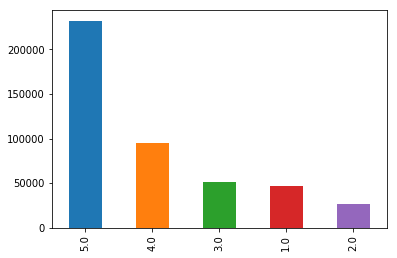

In [16]:
import pandas ## pip3 install pandas, this killed my day had to put the "3"
pandas.Series((Y_train)).value_counts().plot.bar()

In [17]:
import sys
sys.executable

'C:\\Users\\Aysha Kamal\\AppData\\Local\\Programs\\Python\\Python36\\python.exe'

We see that 5-star review are by far the most frequent, and very few people leave a 1-star review. We can also visualize the distribution of our features. We see that most reviews don't have negative words at all (sharp peak around 0), while reviews without any positive words are much rarer. The typical review seems to contain around 10% positive words, and around 5% negative words:

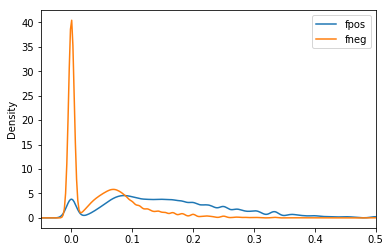

In [19]:
#now had to install skipy (pip3 install scipy) -__-
df = pandas.DataFrame(data=X_train, columns = ['fpos', 'fneg'])
df.plot.kde(xlim=(-0.05, 0.5))


These two examples are just meant to whet your appetite. To find out more, have a look at the Pandas documentation (https://pandas.pydata.org/pandas-docs/stable/tutorials.html).

# Predictor
We are now ready to train our first predictor! Generally it's a good idea to keep it simple at the beginning, so we'll start with a method you will probably remember from high school: **linear regression** (also known as least-squares regression). If you haven't studied the mathematics before or would like to refresh your memory, there are many good materials on the Internet, e.g. on Khanacademy: https://www.khanacademy.org/math/statistics-probability/describing-relationships-quantitative-data Otherwise you can also use the Python libraries as a "black box" - this will be sufficient if you don't plan on working with data a lot.

Later this week we'll learn how to use Google's Tensorflow library to train a linear regression model: however, that will be mostly for pedagogical purposes, and would be a bit of an overkill in practice. The **Scikit**-learn library (http://scikit-learn.org/stable/) has very good implementations of classical predictors such as linear regression:

In [21]:
#DOWNLOAD SKLEARN pip3 install sklearn
from sklearn.linear_model import LinearRegression
lreg = LinearRegression().fit(X_train, Y_train)

print("The coefficient for the fpos variable is", lreg.coef_[0])
print("The coefficient for the fneg variable is", lreg.coef_[1])
print("The intercept is", lreg.intercept_)

The coefficient for the fpos variable is 3.7858833518386943
The coefficient for the fneg variable is -3.961652271328679
The intercept is 3.5480097262375017


Just like this, we have trained our first machine learning model! Since linear regression is a very simple predictor, we can actually understand its inner workings quite well. The intercept is the star rating we would expect for a review that contains neither positive nor negative words (fpos==0 and fneg==0): according to the model, such a review should get about 4 stars on average.
**y=ax + bx^2 + c , if a=0,b=0, y=c ^^**
If the review contains 20% positive words (fpos==0.2) but still no negative words (fneg==0), we would expect the following rating:

In [22]:
features = [[0.2, 0]]
expected_rating_A = lreg.predict(features)[0]
print("The expected rating is %f stars" % expected_rating_A)
# we can also compute this explicitly:
expected_rating_B = lreg.intercept_ + 0.2*lreg.coef_[0] + 0*lreg.coef_[1]
print("This is the same as %f stars" % expected_rating_B)

The expected rating is 4.305186 stars
This is the same as 4.305186 stars


However, if the review contains no positive words (fpos==0) but 20% negative words (fneg==0.2), we expect the following rating:

In [23]:
features = [[0, 0.2]]
expected_rating_A = lreg.predict(features)[0]
print("The expected rating is %f stars" % expected_rating_A)
# we can also compute this explicitly:
expected_rating_B = lreg.intercept_ + 0 * lreg.coef_[0] + 0.2 * lreg.coef_[1]
print("This is the same as %f stars" % expected_rating_B)

The expected rating is 2.755679 stars
This is the same as 2.755679 stars


We see that the more positive words we have in our review, the higher the expected star rating (the coefficient for the first variable is positive).

The more negative words there are in the review, however, the lower is the expected star rating (the coefficient for the second variable is negative). This is what we would intuitively expect.

Remember our two examples from earlier, which contained 100% positive words ("so cute") or 100% negative words ("uncomfortable"). For these two extreme examples, we get a very odd prediction

# Intermediate homework:
- calculate the prediction for 100% pos, and 100% neg review
- repeat this same process for "Apps for Android" dataset

### 100% positive

In [24]:
features = [[1, 0]]
expected_rating_A = lreg.predict(features)[0]
print("The expected rating is %f stars" % expected_rating_A)
# we can also compute this explicitly:
expected_rating_B = lreg.intercept_ + 1*lreg.coef_[0] + 0*lreg.coef_[1]
print("This is the same as %f stars" % expected_rating_B)

The expected rating is 7.333893 stars
This is the same as 7.333893 stars


### 100% negative

In [25]:
features = [[0,1]]
expected_rating_A = lreg.predict(features)[0]
print("The expected rating is %f stars" % expected_rating_A)
# we can also compute this explicitly:
expected_rating_B = lreg.intercept_ + 0*lreg.coef_[0] + 1*lreg.coef_[1]
print("This is the same as %f stars" % expected_rating_B)

The expected rating is -0.413643 stars
This is the same as -0.413643 stars


Since we haven't told our predictor that all ratings must lie between 1 and 5 stars, it became a bit overenthusiastic in its predictions for these extreme examples. We can simply "cut off" these unrealistic results: if the predicted star rating is above 5 stars, we set it to 5 stars, and if it is below 1 star, we set it to 1 star. Now we have a practical prediction algorithm, which we can apply to our training dataset:

### Make modified corrected predictor

In [26]:
def predict_lreg(features):
    expected_rating = lreg.predict(features)
    expected_rating[expected_rating > 5.0] = 5.0
    expected_rating[expected_rating < 1.0] = 1.0
    return expected_rating

pred_train = predict_lreg(X_train) ##predicted the whole training set

### Trying the extremes again: 
(max 5 star, min 1 star)

In [27]:
predict_lreg([[1,0]]) #100% pos

array([5.])

In [28]:
predict_lreg([[0,1]]) #100% pos

array([1.])

### Manual error checking
Let's look at some random examples first to get a feeling how well this works:

In [29]:
def analyze_training_example(i):
    print("Training example number", i)
    print("True rating = %f stars, expected rating = %f stars" % (Y_train[i], 
                                                                  pred_train[i]))
    print("Features = %f / %f" % (X_train[i,0], X_train[i,1]))
    print("Review text = %s" % apps_train[i]['reviewText'])

for i in [0, 10000, 20000, 30000, 50000]: #some random numbers
    analyze_training_example(i)

Training example number 0
True rating = 5.000000 stars, expected rating = 4.056277 stars
Features = 0.181818 / 0.045455
Review text = Oh, how my little grandson loves this app. He's always asking for "Monkey." Grandma has tired of it long before he has. Finding the items on each page that he can touch and activate is endlessly entertaining for him, at least for now. Well worth the $.99.
Training example number 10000
True rating = 4.000000 stars, expected rating = 4.809971 stars
Features = 0.333333 / 0.000000
Review text = Good game for the price.  Nice graphics, enjoyable switchable background music, and simple enough gameplay.  Plays well on my A500.
Training example number 20000
True rating = 5.000000 stars, expected rating = 4.305186 stars
Features = 0.200000 / 0.000000
Review text = I love playing this game.  Gives my brain a nice workout with words and where to put them for more points.
Training example number 30000
True rating = 5.000000 stars, expected rating = 4.088850 stars
Fe

In [30]:
#trying to see why the predictor predicts 3.538736 star to a 5 star, in number 30000
str="Have XM radio in the car while driving. Usually miss the ending. But with this I get the whole show while I relaxing and taking a shower..This is the best appI've ever had. Use while waiting for the doc and last week me and the doc listened to Dragnet. He's putting it on his devise too"

def pos_neg_words_show(text):
    tokens = my_tokenize(text)
    pos=[]
    neg=[]
    for t in tokens:
        if t in positive_words:
            pos.append(t)
        if t in negative_words:
            pos.append(t)
    print(pos)
    print(neg)

pos_neg_words_show(str)

['miss', 'best']
[]


so looks like the above example simply didnt have enough "Positive" words. so "no negative words" didnt help improve the rating

### for baby data set
Not terrible, but far from perfect either. These few examples already show some of the limitations of our approach. For example, example 50000 is a 1-star review which contains only a single negative word ("hangs"), so the predictor overestimates the rating.

Example 20000 likewise overestimates the rating because it counts words like "top" and "fabulous", which don't refer to the product itself in this example.

Example 30000 is not too far off, but it underestimates the rating because it counts "regret" as a negative word and overlooks the preceding "not". **Sophisticated sentiment analyzers need to account for negation**: for example, "not bad" should be treated differently from "bad". **Intensifiers** should also be accounted for: in example 10000, "very disappointed" is stronger than "disappointed", but our predictor doesn't know this.

### Auto Error Checking
While looking at individual examples is important and instructive, we need a systematic way to measure the prediction quality across all examples. Scikit-learn provides different evaluation metrics. The conceptually easiest choice is the **mean absolute error**, which counts by how many stars our predictions are off on average (in either direction).

For example, assume we have three examples with true star ratings of 1, 4, 5, and predicted star ratings of 5, 4, 3. Then the first example is off by 4 stars, the second example by 0 stars (predicted and true rating match exactly), and the third example is off by 2 stars. The mean absolute error is therefore (4 + 0 + 2) / 3 = 2.

In [32]:
from  sklearn.metrics import mean_absolute_error
mae_train = mean_absolute_error(pred_train, Y_train)
print("The mean absolute error on the training data is %f stars" % mae_train)

The mean absolute error on the training data is 0.989731 stars


# 98.973% ERROR !!! So Useless!!!

So it turns out that we actually aren't that far off, although the accuracy on the validation set is a bit worse than on the training set (which should be expected). Once we move to more complex algorithms, however, we'll have to be very careful not to draw premature conclusions from the training set performance: an algorithm may easily achieve perfect accuracy on the training set, and still completely fail on unseen examples! (Like a student with a photographic memory who can reproduce all the answers to all the math problems she has seen before, but hasn't understood the underlying general theory: so she cannot compute any answer if we change the numbers in the problem slightly).

We don't look at the accuracy on the test set yet, because this is the very last step we should do once we are convinced we have found the best predictor we can think of and want to run one final test. For now, we have established that linear regression with the fraction of positive and negative words as features seems to be a reasonable baseline. Can we do better? Stay tuned!

# Certification
### Beginner - none
### Intermediate
calculate the prediction for 100% pos, and 100% neg review, before the cutoff
repeat this same process for "Apps for Android" dataset
### Advanced
build a better sentiment analyzer and comment both your code and your data exploration

# Intro to AI Day 2: Classification versus Regression

On day 1, we have tried to forecast a star rating as a number on a continuous scale: star ratings range from 1 to 5, but the way we trained our linear regression model, it sometimes returned a fractional prediction such as 4.37 stars. In general, prediction algorithms that output a number on a continuous scale are called regression algorithms. Linear regression is the most famous member of this family.

Sometimes all we really need to know is a **binary answer** to a question: Is a review bad or good? Is a user's comment abusive or not? Does a marketing email convert to a sale or not? Prediction algorithms that output either "true" or "false" (instead of a number) are called classification algorithms. While classification and regression are similar in many respects, there are also a couple of important differences: both regarding the algorithms we can use and how we evaluate them.

For example, assume that the only reviews we are really interested in are those with 1, 2 or 3 stars. Maybe we want to flag dissatisfied customers automatically so that we can review what went wrong and reach out to them. If we don't have the star ratings available for all customers, we want to be able to classify them as either satisfied or dissatisfied based on the textual content of their review alone. Let's introduce a variable **D_train that is true if the customer is dissatisfied **(1, 2 or 3 stars), and false if the customer is satisfied (4 stars or better):

In [33]:
def  discretize_targets(Y):
    return Y<=3.0

D_train = discretize_targets(Y_train)
print("The training data contains %f %% dissatisfied customers" % (100.*D_train.mean()))
print(D_train[:10])

The training data contains 27.628008 % dissatisfied customers
[False False False False False False  True  True False False]


A simple classifier would be an algorithm that takes a review text and produces either "true" or "false" as an output. While this is often already useful, it doesn't tell us how **confident** the classifier is about its predictions. Is the algorithm absolutely sure that the review is bad, or is it a 50-50 decision? We may want to handle these cases differently, since some of the algorithm's errors can be more dangerous than others. In general, a classification algorithm can make two different kinds of errors: **false positives** mean that we wrongly flag a satisfied review (D == false) as dissatisfied, while **false negatives** mean that we wrongly flag a dissatisfied review (D == true) as satisfied. Often we will use our classification algorithm only as a screening filter to flag candidates for manual review. A false positive means that the reviewer has to read a lot of good reviews and confirm that there isn't actually a need to take action.

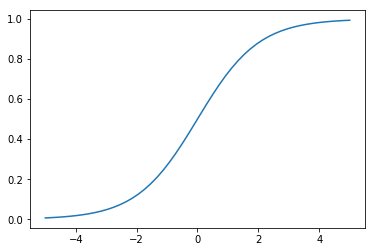

In [34]:
points = numpy.linspace(-5.0, 5.0)
logistic_function = pandas.Series(1/(numpy.exp(-points)+1), index=points)
logistic_function.plot()
##The underlying way in which logistic function works
##Its kinda like a surety vs rating/satisfaction graph, e.g the pc is around
##80% sure at 2, 50% sre at arounf 0 etc.

### Last time we used linear regression, now we use logistics regression.

In [35]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression().fit(X_train, D_train)
# The predict_proba() method produces a matrix with two columns
# the first column contains the probability for the label being "false" (satisfied customer)
# the second column contains the probability for the label being "true" (dissatisfied customer)
# the sum of both columns is 1
# we select the second column with [:,1]
# [:,0] would select the first column
# [1,:] would select the second row
prob2_train = logreg.predict_proba(X_train)[:,1]
pred2_train = prob2_train > 0.5
max_prob2 = numpy.argmax(prob2_train)
min_prob2 = numpy.argmin(prob2_train)

def analyze_training_example_2(i):
    print("Training example number", i)
    print("True rating = %f stars" % Y_train[i])
    print("Expected to be dissatisfied:", pred2_train[i])
    print("Expected probability of being dissatisfied : %f" % prob2_train[i])
    print("Features = %f / %f" % (X_train[i,0], X_train[i,1]))
    print("Review text = %s" % apps_train[i]['reviewText'])
    
analyze_training_example_2(max_prob2)
analyze_training_example_2(min_prob2)

Training example number 6576
True rating = 2.000000 stars
Expected to be dissatisfied: True
Expected probability of being dissatisfied : 0.996558
Features = 0.000000 / 1.000000
Review text = boring
Training example number 1779
True rating = 1.000000 stars
Expected to be dissatisfied: False
Expected probability of being dissatisfied : 0.000182
Features = 1.000000 / 0.000000
Review text = Not fun



# Intermediate HW
Change the treshold from 0.5 to 0.2, and rerun the code.

Give a commentary in plain English about how that changed precision and recall. What does that mean? What is now included that wasn't before? What part of it is good? What is bad from our Task perspective. Remember: our task was to identify Dissatisfied reviews.

https://en.wikipedia.org/wiki/Precision_and_recall

# HW

In [36]:
##Change the treshold from 0.5 to 0.2, and rerun the code.
pred2A_train = prob2_train > 0.2

def analyze_training_example_2A(i):
    print("Training example number", i)
    print("True rating = %f stars" % Y_train[i])
    print("Expected to be dissatisfied:", pred2A_train[i])
    print("Expected probability of being dissatisfied : %f" % prob2_train[i])
    print("Features = %f / %f" % (X_train[i,0], X_train[i,1]))
    print("Review text = %s" % apps_train[i]['reviewText'])
    
analyze_training_example_2A(max_prob2)
analyze_training_example_2A(min_prob2)

Training example number 6576
True rating = 2.000000 stars
Expected to be dissatisfied: True
Expected probability of being dissatisfied : 0.996558
Features = 0.000000 / 1.000000
Review text = boring
Training example number 1779
True rating = 1.000000 stars
Expected to be dissatisfied: False
Expected probability of being dissatisfied : 0.000182
Features = 1.000000 / 0.000000
Review text = Not fun


### HW text
Precision reduced and recall increased! Whenever there is more than 20% probability that the review might be bad, we are flagging it, 20% is a small number honestly to flag a review. On the otherhand, the more we are trying to help people and manually check reviews(even with 80% good probability to be a good review), the more time consuming human work has to be done. So the power of machine learning and automation isn't used to it's potential. It might be good that we are certainly getting most bad reviews and checking them, so that there are no loopholes, but from task perspective the bad part is the reduced automation of flagging.

In [37]:
from sklearn.metrics import precision_score, recall_score
precision2 = precision_score(D_train, pred2_train)
recall2 = recall_score(D_train, pred2_train)
print("For the default threshold (0.5) we get precision = %f "
      "and recall = %f" % (precision2, recall2))

For the default threshold (0.5) we get precision = 0.652288 and recall = 0.229239


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/330px-Precisionrecall.svg.png"/>

#### We only found 22% of the dissatisfied customers, missed 78% of dissatisfied customers(false negatives).
#### Out of the ones we flagged, 65% are actually dissatified, 35% are actually okay.

## HW precision recall check (verify with text)

In [38]:
from sklearn.metrics import precision_score, recall_score
precision2A = precision_score(D_train, pred2A_train)
recall2A = recall_score(D_train, pred2A_train)
print("For the default threshold (0.2) we get precision = %f "
      "and recall = %f" % (precision2A, recall2A))

For the default threshold (0.2) we get precision = 0.372425 and recall = 0.840454


## Precision REDUCED from 65% to 37% 
## Recall increased from 22% to 84%

### Graphing

Precision as function of threshold:


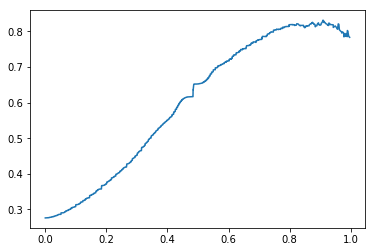

In [39]:
from sklearn.metrics import precision_recall_curve
all_precision2, all_recall2, all_thresh2 = precision_recall_curve(
    D_train, prob2_train)
print("Precision as function of threshold:")
pandas.Series(all_precision2[:-1], index=all_thresh2).plot()

Recall as function of threshold:


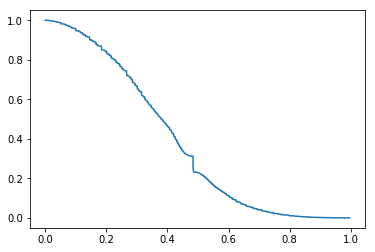

In [40]:
print("Recall as function of threshold:")
pandas.Series(all_recall2[:-1], index=all_thresh2).plot()

Recall as function of precision:


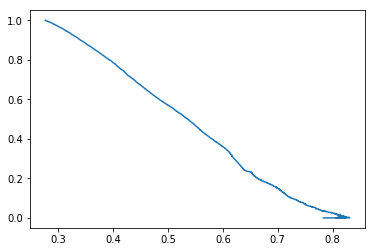

In [41]:
## A trade-off graph, precision vs recall trade-off
print("Recall as function of precision:")
pandas.Series(all_recall2[:-1], index=all_precision2[:-1]).plot()

### Details in the book, here we use it as a Black-Box
watch the precision-recall improvement

Now the precision is 0.565166 and the recall is 0.212573


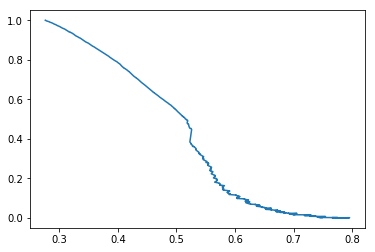

In [42]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
nb = GaussianNB().fit(X_train, D_train)
prob3_train = nb.predict_proba(X_train)[:,1]
pred3_train = prob3_train>0.5
precision3 = precision_score(D_train, pred3_train)
recall3 = recall_score(D_train, pred3_train)
print("Now the precision is %f and the recall is %f" % (precision3, recall3))
all_precision3, all_recall3, all_thresh3 = precision_recall_curve(
    D_train, prob3_train)
pandas.Series(all_recall3[:-1], index=all_precision3[:-1]).plot()

Chapter 6 of NLTK describes Naive-Bayes http://www.nltk.org/book/ch06.html

In [47]:
import platform
print(platform.python_version())

3.6.6


# TensorFlow
Linear Regression

Step 1: Make sure you follow installation guide of TensorFlow and then you will be able to import it. https://www.tensorflow.org/
<br/> `N.B: Tensor flow supports only 3.5 and 3.6 python, higher versions wont work as well.`

In [48]:
import tensorflow as tf

In [49]:
import tensorflow as tf
feat_cols = [tf.feature_column.numeric_column(key="fpos"),
             tf.feature_column.numeric_column(key="fneg")]
model = tf.estimator.LinearRegressor(feature_columns=feat_cols)
get_training_data = tf.estimator.inputs.numpy_input_fn(
                     x={"fpos" : X_train[:,0], "fneg" : X_train[:,1]},
                     y=Y_train, num_epochs=None, shuffle=True)

model.train(input_fn=get_training_data, steps=5000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\AYSHAK~1\\AppData\\Local\\Temp\\tmpdkby2j2p', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002A2620BA630>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 

##### Tensor flow was given the fraction of pos and negative words, it spit out tits estimation. 
Tensor flow was refining and fitting the curve better and better at each step, to compare with the our first model(of linear regression) we find the mean absolute error(auto) / look at absolute values of the predictor(manual)

In [50]:
eval_training_data = tf.estimator.inputs.numpy_input_fn(
                     x={"fpos":X_train[:,0], "fneg": X_train[:,1]},
                     num_epochs=1, shuffle=False)
pred_train_tf = numpy.array([item['predictions'][0] for item in 
                         model.predict(input_fn=eval_training_data)])
mae_train_tf = mean_absolute_error(pred_train_tf, Y_train)
print("The mean absolute error on the training data is %f stars" 
      % mae_train_tf)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\AYSHAK~1\AppData\Local\Temp\tmpdkby2j2p\model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
The mean absolute error on the training data is 1.005123 stars


### Previous absolute error: 98.93%
## With TensorFlow: error : 100.5123%

# NLTK Built In Sentiment Analyzer

### Checking error of the first linear regression, with negation detection included!

In [53]:
##Negation detector : added feature, will it give us better prediction?
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import mark_negation
examples_negation = ["This product wasn't bad.",
                     "This is not a bad product.",
                     "This product was bad.",
                     "This is a bad product."]

for sentence in examples_negation:
    tokens_with_negation = mark_negation(word_tokenize(sentence.lower()))
    print("Sentence =", sentence)
    print(tokens_with_negation)

Sentence = This product wasn't bad.
['this', 'product', 'was', "n't", 'bad_NEG', '.']
Sentence = This is not a bad product.
['this', 'is', 'not', 'a_NEG', 'bad_NEG', 'product_NEG', '.']
Sentence = This product was bad.
['this', 'product', 'was', 'bad', '.']
Sentence = This is a bad product.
['this', 'is', 'a', 'bad', 'product', '.']


In [58]:
#all stopwords=eng_stop words + NEG_ version of all eng_stopwords
negated_stopwords = set(x+"_NEG" for x in eng_stopwords)
all_stopwords = eng_stopwords.union(negated_stopwords)        # set union
    
def tokenize_with_negation(text):
    # split text into lower-case tokens, removing all-punctuation tokens and stopwords
    tokens = []
    for sentence in sent_tokenize(text):
        pretokens = word_tokenize(sentence.lower())
        pretokens = [x for x in pretokens if any(i.isalpha() for i in x)]
        pretokens = mark_negation(pretokens)
        tokens.extend(x for x in pretokens if x not in all_stopwords)
    return tokens

##example of tokening with negation:

print(apps_train[5000]['reviewText'])
print(tokenize_with_negation(apps_train[5000]['reviewText']))

Starts out pretty easy, but doesn't take long before you have &#34;hung&#34; yourself.  Some of the words they are looking for are quite long. I am pretty good at word games, but this one is a challege!  On a lower challenge level, pretty easy to win.
['starts', 'pretty', 'easy', "n't", 'take_NEG', 'long_NEG', 'hung_NEG', 'words', 'looking', 'quite', 'long', 'pretty', 'good', 'word', 'games', 'one', 'challege', 'lower', 'challenge', 'level', 'pretty', 'easy', 'win']


### Training again with negation included

In [59]:
## neagtion of negative words is negative
## neagtion of negative words is negative
all_positive_words = positive_words.union({x+"_NEG" for x in negative_words})
all_negative_words = negative_words.union({x+"_NEG" for x in positive_words})

def pos_neg_fraction_with_negation(text):
    tokens = tokenize_with_negation(text)
    # count how many positive and negative words occur in the text
    count_pos, count_neg = 0, 0
    for t in tokens:
        if t in all_positive_words:
            count_pos += 1
        if t in all_negative_words:
            count_neg += 1
    count_all = len(tokens)
    if count_all != 0:
        return count_pos/count_all, count_neg/count_all
    else:  # avoid division by zero
        return 0., 0.
    
pos_example = 'This is a good, great, fantastic, amazing, wonderful, super product!!!'
neg_example = 'This is a bad, atrocious, terrible, dreadful, awful, abysmal product!!!'
print(pos_neg_fraction_with_negation(pos_example))
print(pos_neg_fraction_with_negation(neg_example))

(0.8571428571428571, 0.0)
(0.0, 0.8571428571428571)


In [61]:
pos_example_neg = 'This is not a good, great, fantastic, amazing, wonderful, super product!!!'
neg_example_neg = 'This is not a bad, atrocious, terrible, dreadful, awful, abysmal product!!!'
print(pos_neg_fraction_with_negation(pos_example_neg))
print(pos_neg_fraction_with_negation(neg_example_neg))

(0.0, 0.8571428571428571)
(0.8571428571428571, 0.0)


###### as we can see above, the neagtion was picked up, and even though positive words were used, they were neagative meaning and so they went on to the 'fneg' side

In [62]:
###ALSO TAKES YEARS TO RUN
def dataset_to_matrix_with_neg(data):
    return numpy.array([list(pos_neg_fraction_with_negation(item['reviewText'])) for item in data])

X_train_neg = dataset_to_matrix_with_neg(apps_train)

In [63]:
lreg_neg = LinearRegression().fit(X_train_neg, Y_train)
pred_train_neg = lreg_neg.predict(X_train_neg)
mae_train_with_neg = mean_absolute_error(pred_train_neg, Y_train)
print("Now the mean absolute error on the training data is %f stars" % mae_train_with_neg)

Now the mean absolute error on the training data is 0.972192 stars


## Error has reduced from 98.97% to 97.22% Great!! Still Worse :(

# Random Forest - NLTK blackbox
Donno how it works, it works is all I know, its and nltk's built in predictor.


### on X_traing_neg

In [64]:
from sklearn.ensemble import RandomForestRegressor
rf_neg = RandomForestRegressor().fit(X_train_neg, Y_train)
pred_train_rf_neg = rf_neg.predict(X_train_neg)
mae_train_rf_neg = mean_absolute_error(pred_train_rf_neg, Y_train)
print("A nonlinear regressor achieves a MAE of %f stars" % mae_train_rf_neg)

A nonlinear regressor achieves a MAE of 0.915068 stars


## Error reduced from 97.22% to 91.5% ???!!! Amazing!

### on X_train (original data, no negation)

In [65]:
rf = RandomForestRegressor().fit(X_train, Y_train)
pred_train_rf = rf.predict(X_train)
mae_train_rf = mean_absolute_error(pred_train_rf, Y_train)
print("A nonlinear regressor achieves a MAE of %f stars" % mae_train_rf)

A nonlinear regressor achieves a MAE of 0.946836 stars


## Error reduced from 98.87% to 94.68% ???!!! Really reduced a lot !!!

so we did a lot of linear regression and prediction, how to they compare?which has been the worst? which is the best. For sentiment analysis using ONLY POS & NEG word percentage!
# *Best so far?* TF < original LR < Negated LR < original with RF < negated RF

### Short-List Promising Models
Notes:

**If the data is huge, you may want to sample smaller training sets so you can train many different models in a reasonable time** (be aware that this penalizes complex models such as large neural nets or Random Forests). Once again, try to automate these steps as much as possible.

1. Train many quick and dirty models from different categories (e.g., linear, naive Bayes, SVM, Random Forests, neural net, etc.) using standard parameters.
2. Measure and compare their performance. For each model, use **N-fold cross-validation** (not taught) and compute the mean and standard deviation of the performance measure on the N folds.
3. Analyze the most significant variables for each algorithm.
4. Analyze the types of errors the models make. What data would a human have used to avoid these errors?
5. Have a quick round of feature selection and engineering.
6. Have one or two more quick iterations of the five previous steps.
7. Short-list the top three to five most promising models, preferring models that make different types of errors.

**Source: p. 646. Hands-on Machine Learning** - Application perspective.

### Advanced Homework
* Add features
* Explain which features you chose, implement them, and write a commentary on your results
* Feel welcome to use NLTK's built-in sentiment analyzer or any other research that you can find and understand

# Intro to AI: Week 4 Day 3 
### Improvement of Sentiment Analyzer

In [103]:
## checking presence of data
##lets find the longest review in training set
def find_longest_review(data_given):
    mx=0
    ret=0;
    for i in apps_train:
        length=len(i['reviewText'])
        if length>5000:
            mx=length
            ret=i
            break
    print(mx)
    return ret
            
review_long=find_longest_review(apps_train)
print(review_long)

5209
{'reviewerID': 'A1X1CEGHTHMBL1', 'asin': 'B004GMP53U', 'reviewerName': 'jjceo', 'helpful': [0, 0], 'reviewText': "Posted at 8:53 AMGame Play:The game is very similar to the old Pacman game even to the point where you have a thumb joystick to move your action figure to run the maze and collect the dots. For me unfortunately the joystick is on the LH side of the game and I am right handed so the game is played with my most uncoordinated hand. There is a pause button on the top of the LH side of the screen.The controls take time to get used to and it is difficult at best in an open room to move the character to where you want it to go. You will find that for precise movements you must tap the joystick on the side of the direction you want to move in and it will move in one space increments. It is difficult to try to move precisely while trying to clear the maze and have multiple enemies fluidly coming after you while you struggle to get one colored dot. You have slid your thumb off o

In [107]:
## random data
print(apps_train[5000]['reviewText'])

Starts out pretty easy, but doesn't take long before you have &#34;hung&#34; yourself.  Some of the words they are looking for are quite long. I am pretty good at word games, but this one is a challege!  On a lower challenge level, pretty easy to win.


# NLTK built in sentiment analyzer

google nltk vader, 
http://www.nltk.org/howto/sentiment.html
analyzes MANY aspect and tells us , foe each sentence, how positivw, negtive anf neutral it is!

In [108]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
text = review_long['reviewText']  #a review longer than 5000 words, we picked up
for s in sent_tokenize(text):
    print(s)
    print(sia.polarity_scores(s))

Posted at 8:53 AMGame Play:The game is very similar to the old Pacman game even to the point where you have a thumb joystick to move your action figure to run the maze and collect the dots.
{'neg': 0.0, 'neu': 0.954, 'pos': 0.046, 'compound': 0.1779}
For me unfortunately the joystick is on the LH side of the game and I am right handed so the game is played with my most uncoordinated hand.
{'neg': 0.073, 'neu': 0.697, 'pos': 0.23, 'compound': 0.6344}
There is a pause button on the top of the LH side of the screen.The controls take time to get used to and it is difficult at best in an open room to move the character to where you want it to go.
{'neg': 0.052, 'neu': 0.795, 'pos': 0.153, 'compound': 0.5859}
You will find that for precise movements you must tap the joystick on the side of the direction you want to move in and it will move in one space increments.
{'neg': 0.0, 'neu': 0.906, 'pos': 0.094, 'compound': 0.25}
It is difficult to try to move precisely while trying to clear the maz

`So vader did quite a good job really, of picking up the tone of each of the sentences`

Now we will extract information from here and perform prdiction;
6 features from here, also we will keep the previous fpos and fneg features and a length feature, making a total of 9 features. Also added the percent of exclamation sign, so 10 features!

In [116]:
## ALSO WILL TAKE YEARS TO RUN
def sia_features(dataset):
    """For each review text in the dataset, extract:
       (1) the mean positive sentiment over all sentences
       (2) the mean neutral sentiment over all sentences
       (3) the mean negative sentiment over all sentences
       (4) the maximum positive sentiment over all sentences
       (5) the maximum neutral sentiment over all sentences
       (6) the maximum negative sentiment over all sentences"""
    feat_matrix = numpy.empty((len(dataset), 6)) #row,col
    for i in range(len(dataset)):
        sentences = sent_tokenize(dataset[i]['reviewText'])
        nsent = len(sentences)
        if nsent:
            sentence_polarities = numpy.empty((nsent, 3))
            for j in range(nsent):
                polarity = sia.polarity_scores(sentences[j])
                sentence_polarities[j, 0] = polarity['pos']
                sentence_polarities[j, 1] = polarity['neu']
                sentence_polarities[j, 2] = polarity['neg']
            feat_matrix[i, 0:3] = numpy.mean(sentence_polarities, axis=0) # mean over the columns
            feat_matrix[i, 3:6] = numpy.max(sentence_polarities, axis=0) # maximum over the columns
        else:
            feat_matrix[i, 0:6] = 0.0
    return feat_matrix

sia_tr = sia_features(apps_train)

In [117]:
print(sia_tr[:10])

[[0.2244     0.7224     0.0532     0.667      1.         0.266     ]
 [0.27375    0.72625    0.         0.444      1.         0.        ]
 [0.11785714 0.878      0.00414286 0.804      1.         0.029     ]
 [0.38566667 0.61433333 0.         0.478      0.746      0.        ]
 [0.49133333 0.481      0.02766667 0.818      0.868      0.083     ]
 [0.266      0.734      0.         0.292      0.76       0.        ]
 [0.14755556 0.83111111 0.02133333 0.385      1.         0.119     ]
 [0.122      0.878      0.         0.244      1.         0.        ]
 [0.3155     0.6845     0.         0.5        0.869      0.        ]
 [0.26033333 0.73966667 0.         0.468      1.         0.        ]]


In [114]:
### Just some numpy practice in the mean time!
testmat = numpy.arange(12.).reshape((3, 4))
print(testmat)
print(numpy.max(testmat, axis=0))
print(numpy.mean(testmat, axis=1))

[[ 0.  1.  2.  3.]
 [ 4.  5.  6.  7.]
 [ 8.  9. 10. 11.]]
[ 8.  9. 10. 11.]
[1.5 5.5 9.5]


#### *Adding the length feature* : if someone writes a REALLY long review, either they are REALLY satisfied or REALLY unhappy, but someone might also just want to write details of their experience

In [120]:
def len_features(dataset):
    """Add two features:
       (1) length of review (in thousands of characters) - truncate at 2,500
           (cuz very long is very long anyways)
       (2) percentage of exclamation marks (in %)"""
    feat_matrix = numpy.empty((len(dataset), 2))
    for i in range(len(dataset)):
        text = dataset[i]['reviewText']
        feat_matrix[i, 0] = len(text) / 1000.
        if text:
            feat_matrix[i, 1] = 100. * text.count('!') / len(text)
        else:
            feat_matrix[i, 1] = 0.0
    feat_matrix[feat_matrix>2.5] = 2.5
    return feat_matrix

len_tr = len_features(apps_train)

In [121]:
## previous and new features
print(X_train_neg.shape, sia_tr.shape, len_tr.shape)

(451730, 2) (451730, 6) (451730, 2)


### Then predict with the original Linear regression (with negated data)

In [122]:
#stack horizontally(meaning combining all the features matrices - 1 old, and 2 new)
X_train_augmented = numpy.concatenate((X_train_neg, sia_tr, len_tr), axis=1)
# ^ this line is common for all, just making the X-train here
lreg_augmented = LinearRegression().fit(X_train_augmented, Y_train)
pred_train_augmented = lreg_augmented.predict(X_train_augmented)
mae_train_augmented = mean_absolute_error(pred_train_augmented, Y_train)
print("Now the mean absolute error on the training data is %f stars" % mae_train_augmented)

Now the mean absolute error on the training data is 0.886206 stars


# :0 :0 :0 Error is now *88.62%* (2 features error was 97% and now is 10 features)
original linear regression with neagation (with only fpos and fneg)

### Now Predict with 10 features (negated included) in Random forest

In [124]:
#random forest
rf_augmented = RandomForestRegressor().fit(X_train_augmented, Y_train)
rfpred_train_augmented = rf_augmented.predict(X_train_augmented)
mae_train_rf_augmented = mean_absolute_error(rfpred_train_augmented, Y_train)
print("For the RF, it is %f stars" % mae_train_rf_augmented)

For the RF, it is 0.341048 stars


# NOWAY!! Error: 34% ??!! WOAH! how come? Random forest is Awesome! (from previous RF 94%)
### It was nltk sentiment analyzer + negation + 10 features + random forest

# Validation
#### Now finally we will run the best ML algo we found on our 'validation' set, to see if the algo really is a good predictor, or did the algo simply overfit the test set and therefore was showing really less error

we will validate on the negation+the sia+the len feature set=10 features, like above.

In [128]:
X_valid_neg = dataset_to_matrix_with_neg(apps_valid) #2 features
sia_valid = sia_features(apps_valid) # 6 features
len_valid = len_features(apps_valid) # 2 features

X_valid_augmented = numpy.concatenate((X_valid_neg, sia_valid, len_valid), axis=1)

In [129]:
## Linear regression and random forest fitting
pred_valid_augmented = lreg_augmented.predict(X_valid_augmented)
pred_valid_rf_augmented = rf_augmented.predict(X_valid_augmented)

In [130]:
Y_valid = dataset_to_targets(apps_valid)

In [131]:
mae_valid_augmented = mean_absolute_error(pred_valid_augmented, Y_valid)
print("On the validation set, we get %f error for the linear regression" % mae_valid_augmented)
mae_valid_rf_augmented = mean_absolute_error(pred_valid_rf_augmented, Y_valid)
print("And %f for the random forest regression" % mae_valid_rf_augmented)

On the validation set, we get 0.892178 error for the linear regression
And 0.872144 for the random forest regression


## Oh Damn! Linear Regression : TestSet=88.62% and ValidationSet=89.21%    RandomForest TestSet=34%, ValidationSet=87.21%
Clearly Random forest overestimated :/ But Linear Regression actually *predicted* . Overall picture, random forest is still good, it **did** pick something up.


# Homework for certification

Refactor the code above:

"*Be lazy. Not just lazy but proactively, agressively lazy.*" Remove duplication. Create a single function that takes in data and spits out all success metrics across all of your algos.

Where to go from here?
- unigrams (NLTK)
- word vector (gensim, glove, word2vec)
- recurrent neural net
- convolutional neural net
<br>

https://www.oreilly.com/learning/perform-sentiment-analysis-with-lstms-using-tensorflow

http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/

https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/